This notebook aims to build a baseline model on the Breast Cancer IDC histopathology images.

Let's try a new workflow compared to baseline:
- Use resnet18 instead resnet24 since we have smaller images (50\*50)
- Try changing stage-1 learning rate. Instead of the point of max slope (1e-2), we pick a point with least loss (1e-1).
- Try a 4-stage strategy:<br>
-- Train with last layer frozen <br>
-- Then, train with all layers unfrozen <br>
-- Then, train with last 4 layers unfrozen <br>
-- Then, train with last 2 layers unfrozen 

In [1]:
%matplotlib inline 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib as plt
import matplotlib.pyplot as pyplt
import matplotlib.image as mpimg
from skimage import io

In [3]:
import wget
import time
import os
import copy

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [5]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *

In [6]:
fastai.__version__

'1.0.60'

In [7]:
data_root = "/home/ubuntu/datasets/breast-histopathology-images/"

In [8]:
!ls -l $data_root | head -5

total 3283148
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10253
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10254
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10255
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10256
ls: write error: Broken pipe


In [9]:
!ls -l $data_root | tail -5

drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9382
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9383
-rw-rw-r--   1 ubuntu ubuntu 3326820824 Jan 31 15:54 breast-histopathology-images.zip
drwxr-xr-x 281 ubuntu ubuntu      12288 Feb  2 17:52 IDC_regular_ps50_idx5
-rw-r--r--   1 ubuntu ubuntu   33957737 Feb 18 22:20 train_labels.csv


### Create the databunch

This section extensively uses code from Amerii's kernel from here: https://www.kaggle.com/amerii/breast-cancer-classification-end-to-end

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
additional_aug=[*zoom_crop(scale=(0.95,1.05), do_rand=False), 
#                     brightness(change=(0.05, 0.05))
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.1, xtra_tfms=additional_aug)

In [12]:
fnames=get_files(data_root, recurse=True)
fnames[:5], fnames[-5:]

([PosixPath('/home/ubuntu/datasets/breast-histopathology-images/train_labels.csv'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/breast-histopathology-images.zip'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2051_y1451_class1.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2751_y1401_class1.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1251_y1701_class1.png')],
 [PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x1801_y451_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x2051_y2051_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x951_y2451_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x1051_y2001_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-image

In [13]:
fnames.pop(0)
fnames.pop(0)
fnames[:5]

[PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2051_y1451_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2751_y1401_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1251_y1701_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2351_y1001_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1951_y1001_class1.png')]

In [23]:
pattern= r'([^/_]+).png'
data = ImageDataBunch.from_name_re(data_root, fnames, pattern, ds_tfms=tfms, size=50, bs=256,num_workers=4
                                  ).normalize()

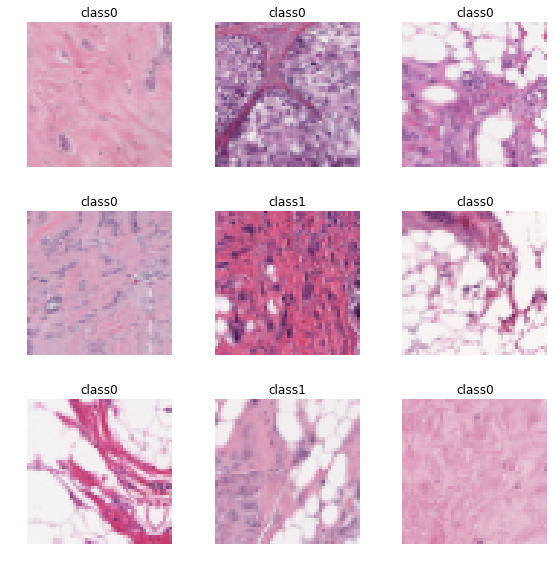

In [24]:
data.show_batch(rows=3, figsize=(8,8))

In [31]:
arch = models.resnet18
learn= cnn_learner(data, arch, metrics=[accuracy, error_rate], model_dir='/home/ubuntu/outputs/working/')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


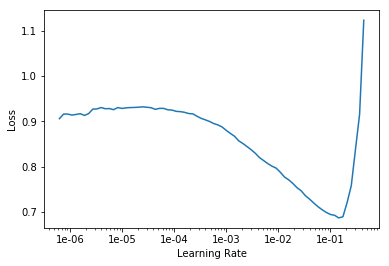

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
# Tried lr=1e-1 but loss keep increasing
lr=1e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.305091,0.333270,0.863552,0.136448,02:23
1,0.294799,0.280419,0.881631,0.118369,02:24
2,0.282309,0.300421,0.872209,0.127791,02:24
3,0.272864,0.283423,0.880875,0.119125,02:24
4,0.266509,0.286021,0.878532,0.121468,02:24


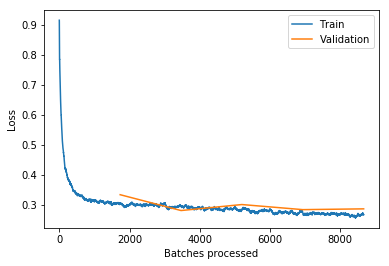

In [34]:
learn.recorder.plot_losses()

In [35]:
learn.save('BC-IDC-v2-stage-1-resnet18')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


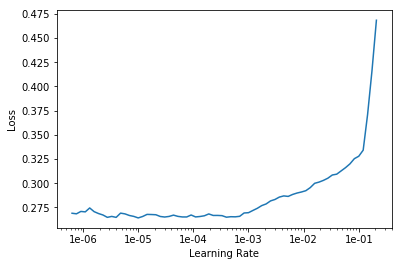

In [36]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [37]:
# Let's try only 2 epochs. So instead of using slice(1e-6,1e-5), we can go slightly higher
learn.fit_one_cycle(2,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.262887,0.280475,0.880631,0.119369,02:22
1,0.267735,0.279442,0.881172,0.118828,02:23


In [38]:
learn.save('BC-IDC-v2-stage-2-resnet18')

In [40]:
learn.freeze_to(-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


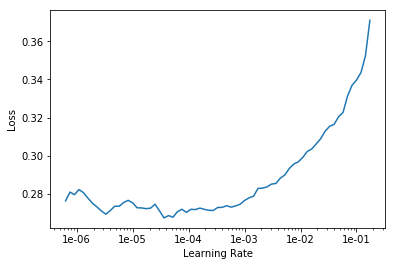

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(3,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.263789,0.284438,0.879839,0.120161,02:23
1,0.249784,0.268775,0.886316,0.113684,02:23
2,0.257227,0.275203,0.883550,0.116450,02:24


In [43]:
learn.freeze_to(-2)
learn.fit_one_cycle(2,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.250907,0.276756,0.882343,0.117657,02:23
1,0.249473,0.272286,0.884856,0.115144,02:25


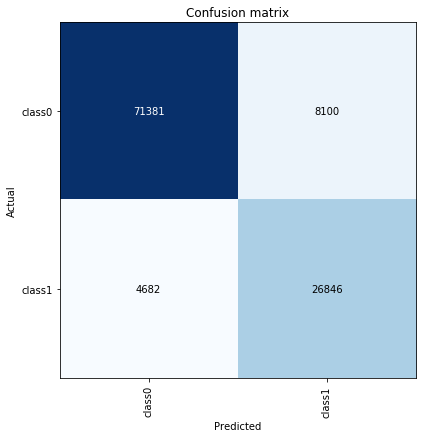

In [45]:
interp= ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

In [49]:
# interp= ClassificationInterpretation.from_learner(learn)
# losses,idxs = interp.top_losses()
# len(data.valid_ds)==len(losses)==len(idxs)
# interp.plot_top_losses(9, figsize=(15,11))

### Conclusion

Results for the exploration
- Used resnet18 instead resnet24 since we have smaller images (50\*50)  // No signifiant change. In fact resnet34 seems slightly better
<br><br>
- Tried changing stage-1 learning rate. Instead of the point of max slope (1e-2), we pick a point with least loss (1e-1). // Learning Rate 1e-2 (w max slope) works MUCH better.
<br><br>
- Tried a 4-stage strategy: // Did NOT help much <br>
-- Train with last layer frozen <br>
-- Then, train with all layers unfrozen <br>
-- Then, train with last 4 layers unfrozen <br>
-- Then, train with last 2 layers unfrozen 